# Classification Tree and Random Forest

In [50]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_roc_curve

from sklearn.inspection import permutation_importance

from sklearn.tree import plot_tree, DecisionTreeClassifier

In [2]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# Create X matrix of regressor variables
X = df.drop(['DEATH_EVENT'], axis = 1)

In [5]:
# Create y vector of regressand variable DEATH_EVENT
y = df['DEATH_EVENT']

In [6]:
ratio_death = df[df["DEATH_EVENT"] == 1].DEATH_EVENT.sum() / df.DEATH_EVENT.count()
print(f"Verhältnis positiver vs negativer Ausprägungen in der Zielvariable: {ratio_death}")

Verhältnis positiver vs negativer Ausprägungen in der Zielvariable: 0.3210702341137124


In [7]:
##split
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns="time"), y , test_size=0.30, random_state=3)

##standardize (around 71% acc on val set)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)




# Classification Tree

In [8]:
ct_2 = DecisionTreeClassifier(max_depth=2)

In [63]:
model_dt = DecisionTreeClassifier()

In [64]:
ct_2.fit(X_train, y_train)
model_dt.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier()

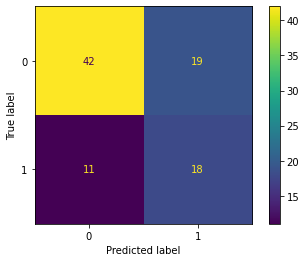

In [65]:
plot_confusion_matrix(model_dt, X_test_sc, y_test);

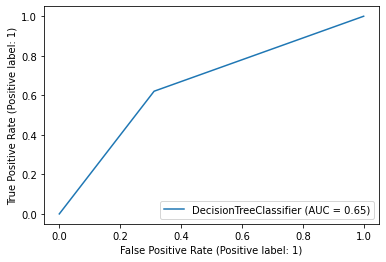

In [66]:
plot_roc_curve(model_dt, X_test_sc, y_test);

In [69]:
y_pred = model_dt.predict(X_test_sc)

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.69      0.74        61
           1       0.49      0.62      0.55        29

    accuracy                           0.67        90
   macro avg       0.64      0.65      0.64        90
weighted avg       0.69      0.67      0.68        90



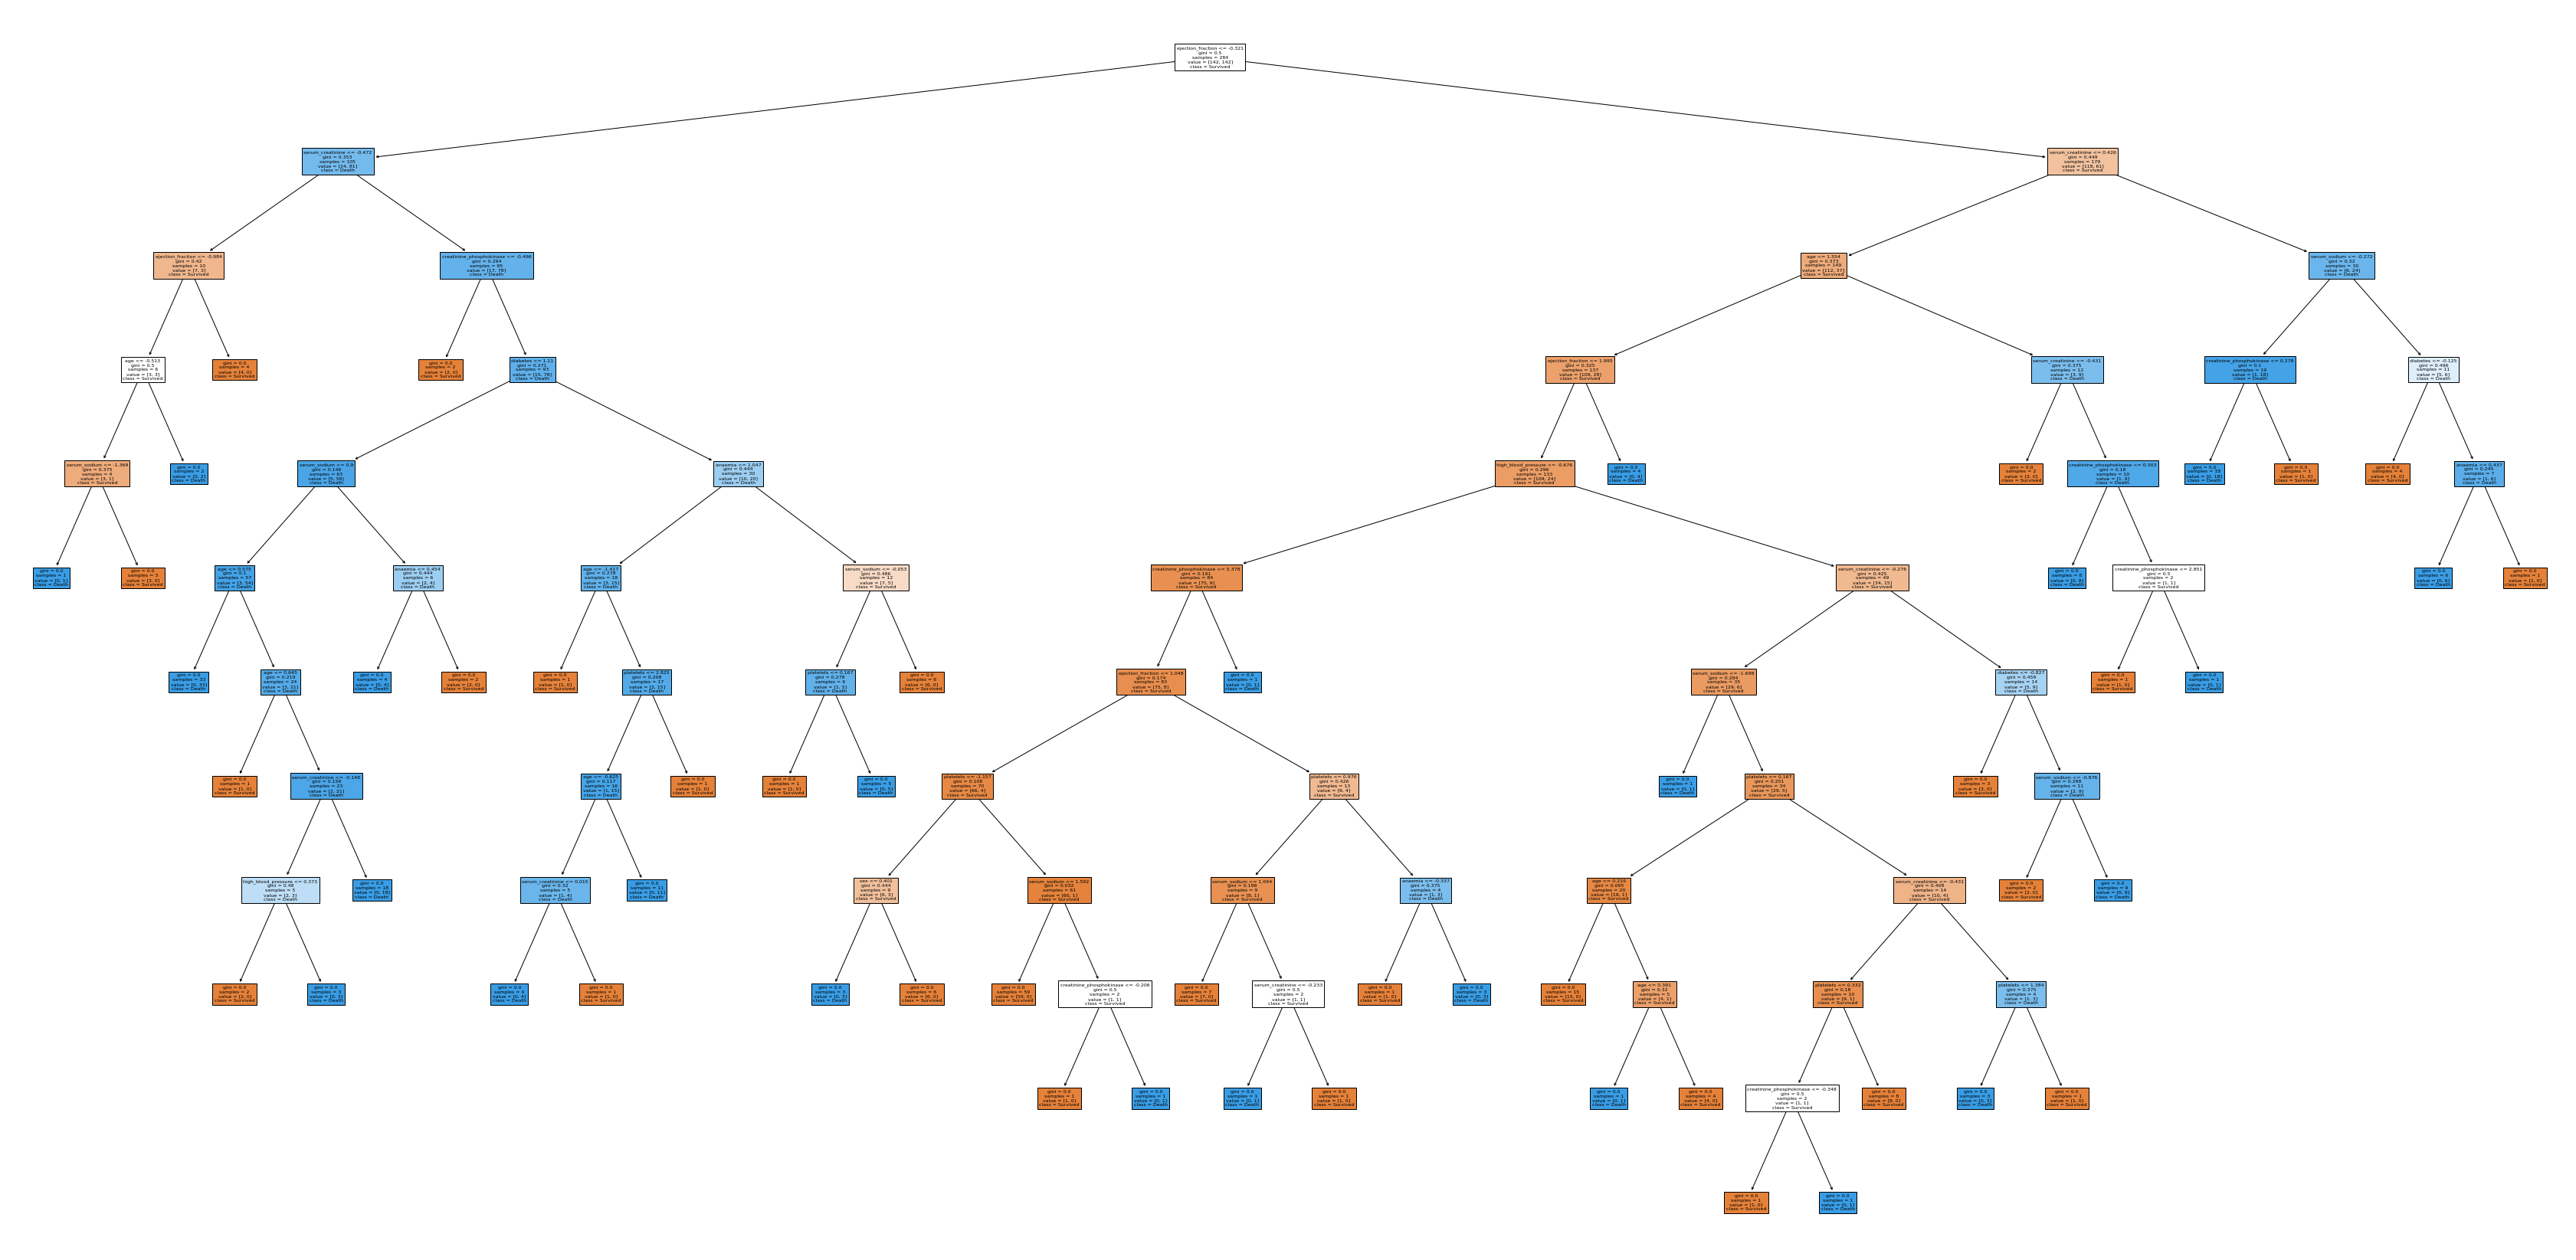

In [57]:
plt.figure(figsize=(60,30))
plot_tree(model_dt, feature_names = X.columns,class_names=['Survived', "Death"],filled=True);

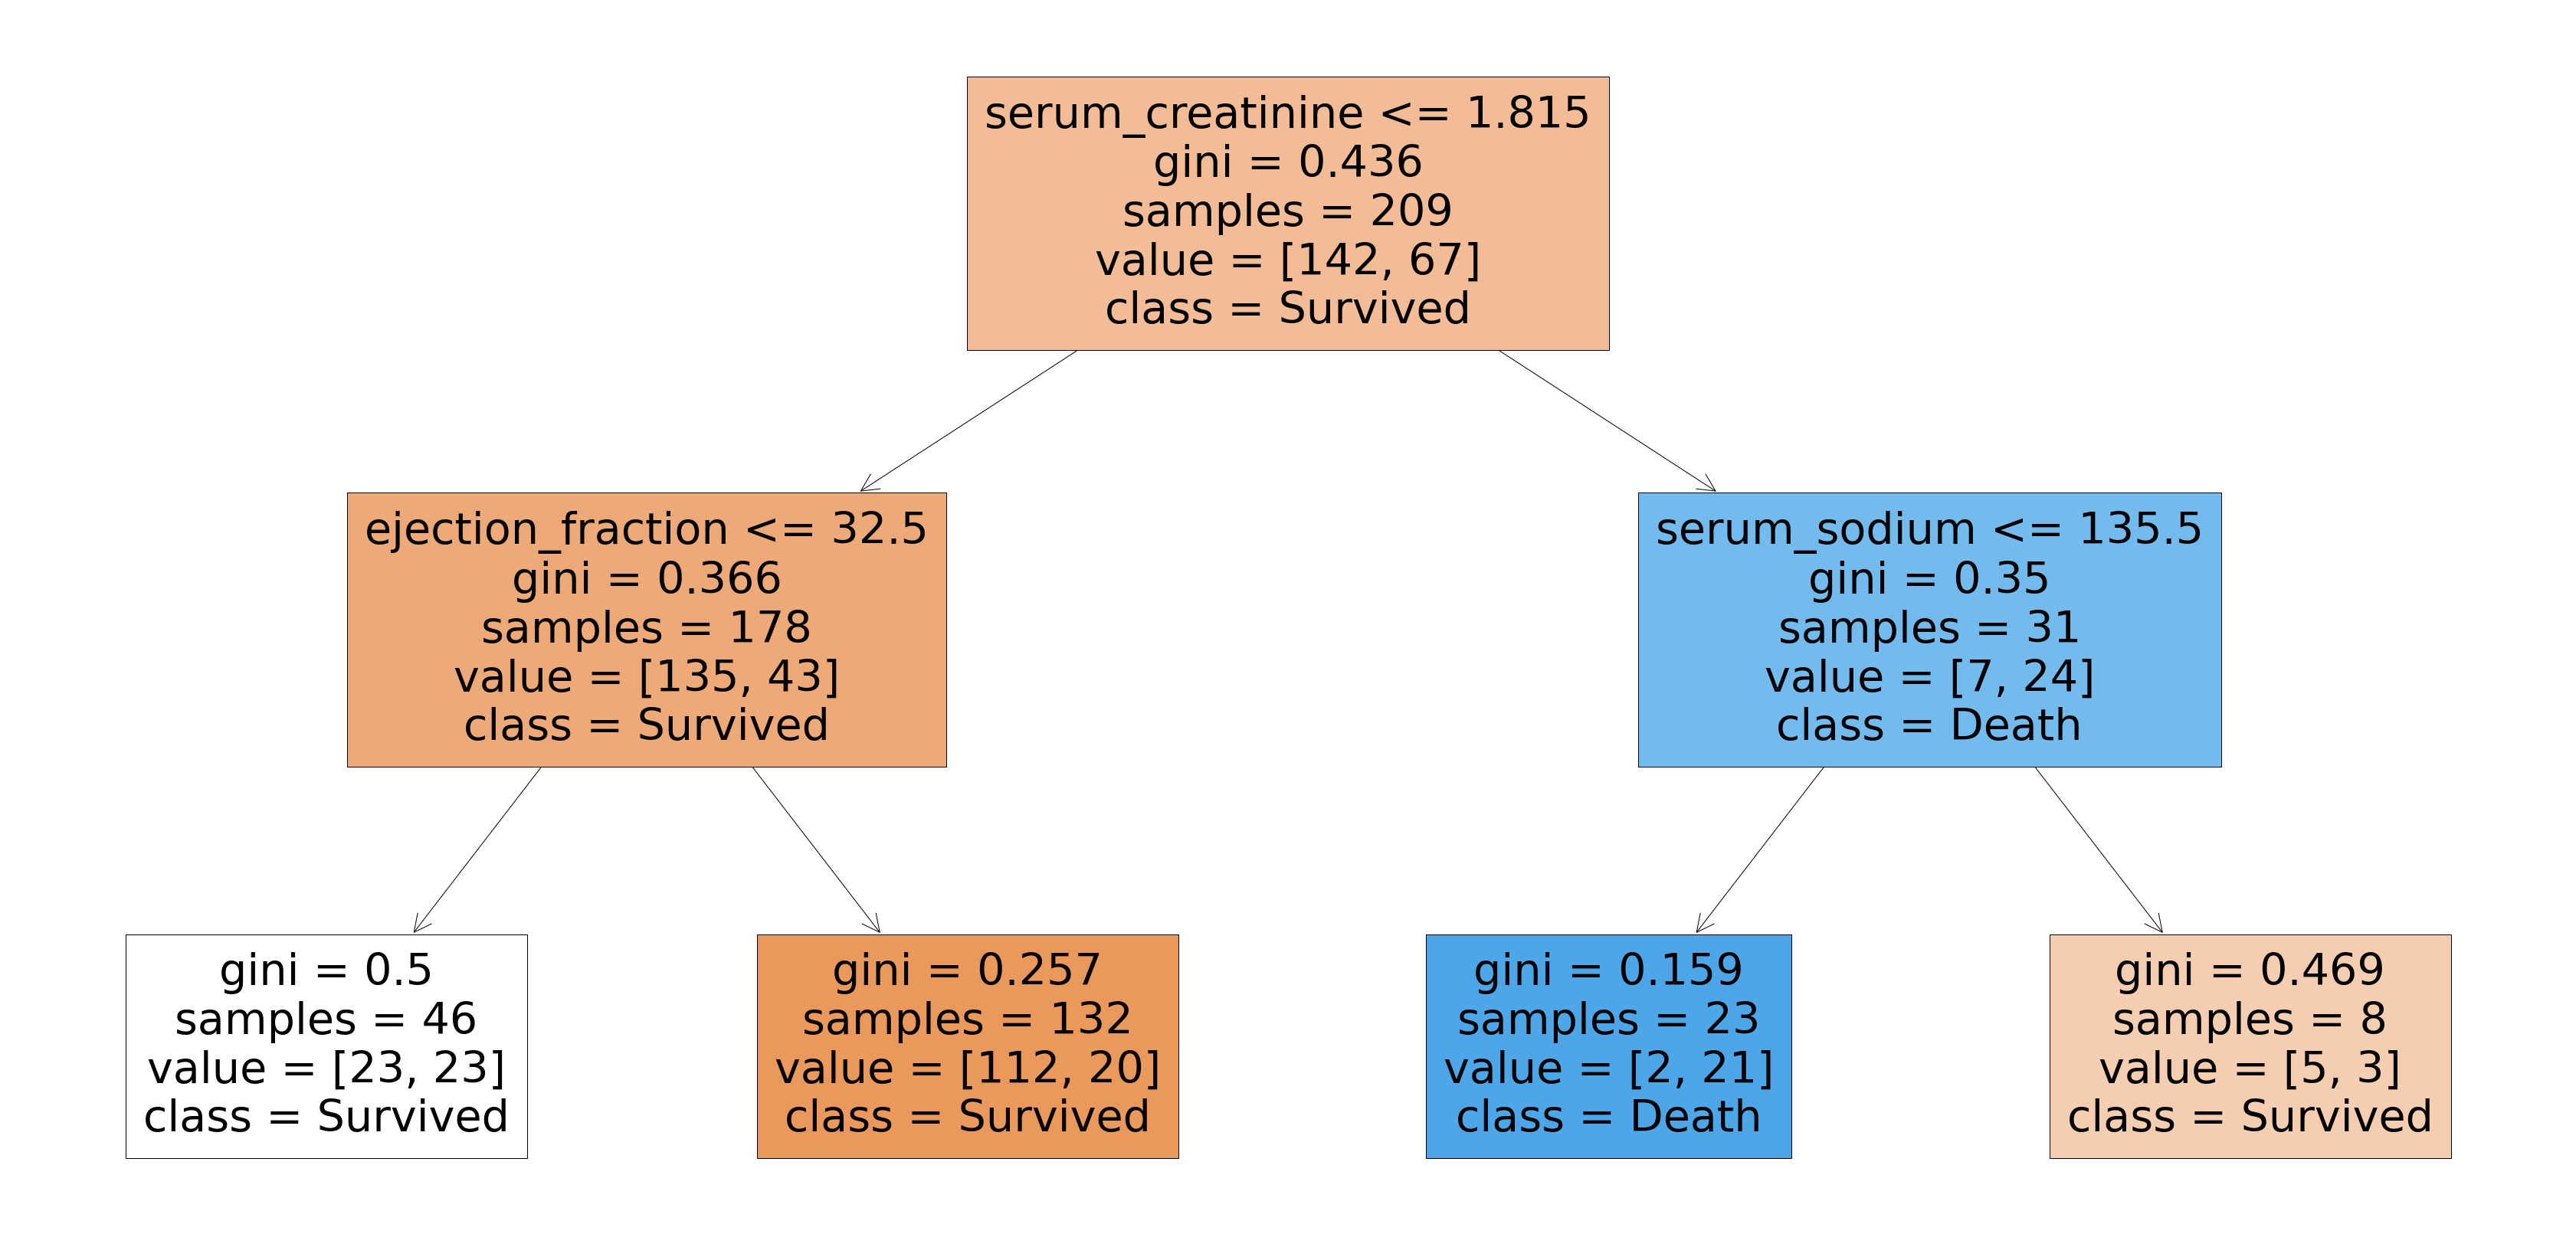

In [58]:
plt.figure(figsize=(60,30))
plot_tree(ct_2, feature_names = X.columns,class_names=['Survived', "Death"],filled=True);

# Random Forest

### 1. Durchgang: Ursprüngliche Daten (standardisiert)

In [15]:
rf = RandomForestClassifier()

In [16]:
rf.fit(X_train_sc, y_train)

RandomForestClassifier()

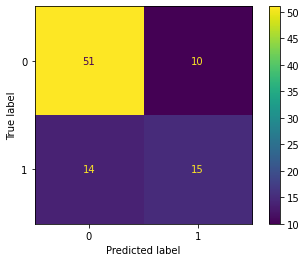

In [17]:
plot_confusion_matrix(rf, X_test_sc, y_test);

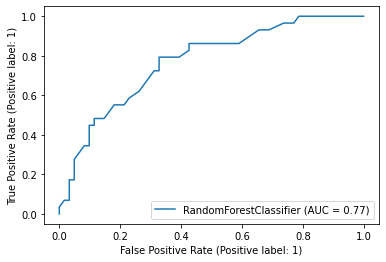

In [18]:
plot_roc_curve(rf, X_test_sc, y_test);

### 2. Durchgang: SMOTE Upsampling Daten

In [19]:
#Experiment: SMOTE UPSAMLING

oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train_sc, y_train)

print(f"Neues Verhältnis nach SMOTE Anwendung:{y_train_sm[y_train_sm == 1].sum() / len(y_train_sm)}")


Neues Verhältnis nach SMOTE Anwendung:0.5


In [20]:
rf_sm = RandomForestClassifier()
rf_sm.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

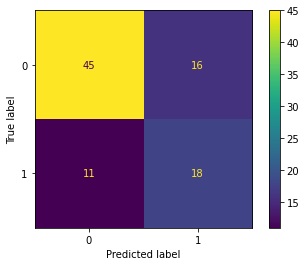

In [21]:
plot_confusion_matrix(rf_sm, X_test_sc, y_test);

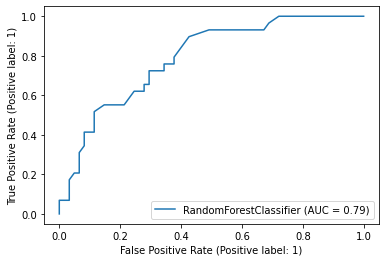

In [22]:
plot_roc_curve(rf_sm, X_test_sc, y_test);

### 3. Durchgang: PCA Daten

In [23]:
pca = PCA(n_components=5)
X_train_pca = pd.DataFrame(data = pca.fit_transform(X_train_sc), columns=['pc1','pc2','pc3','pc4','pc5'])
X_test_pca = pd.DataFrame(data = pca.transform(X_test_sc), columns=['pc1','pc2','pc3','pc4','pc5'])

In [24]:
rf_pca = RandomForestClassifier()
rf_pca.fit(X_train_pca, y_train)

RandomForestClassifier()

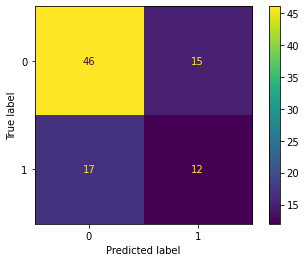

In [25]:
plot_confusion_matrix(rf_pca, X_test_pca, y_test);

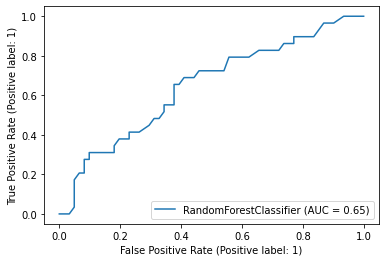

In [26]:
plot_roc_curve(rf_pca, X_test_pca, y_test);

### 4. Durchgang: Beste Datengrundlage und Hyperparameter Tuning

In [27]:
n_estimators=list(range(400,1000,100))
# Maximum number of levels in a tree
max_depth = list(range(4,13,4))
# The minimum number of samples required to be at a leaf node
min_samples_leaf=[1,2,5,7]
# Minimum number of samples required to split an internal node
min_samples_split=list(range(2,9,2))
# Number of fearures to be considered at each split
max_features=['auto','sqrt']


# Hyperparameters dict
param_grid = {"n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "max_features":max_features}

In [28]:
params = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_leaf': [5, 10, 20, 50],
    'max_features': [2,3,4],
    'n_estimators': [30, 50, 100, 200, 300]
}

In [29]:
rf_tune = RandomForestClassifier()
rf_tune = RandomizedSearchCV(rf_tune, param_grid, cv=2, scoring = "roc_auc")
rf_tune.fit(X_train_sc,y_train)

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [4, 8, 12],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 7],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [400, 500, 600, 700,
                                                         800, 900]},
                   scoring='roc_auc')

In [30]:
print(rf_tune.best_params_)
print(rf_tune.best_estimator_)

{'n_estimators': 600, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 8}
RandomForestClassifier(max_depth=8, min_samples_split=4, n_estimators=600)


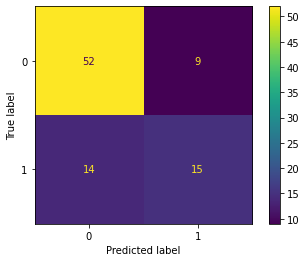

In [31]:
plot_confusion_matrix(rf_tune, X_test_sc, y_test);

### Final Evaluation using ROC-AUC Curve & Score

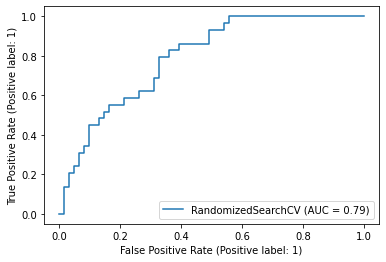

In [32]:
plot_roc_curve(rf_tune, X_test_sc, y_test);

age, Score: 0.0227
anaemia, Score: -0.0095
creatinine_phosphokinase, Score: -0.0007
diabetes, Score: 0.0018
ejection_fraction, Score: 0.1647
high_blood_pressure, Score: -0.0032
platelets, Score: -0.0052
serum_creatinine, Score: 0.0834
serum_sodium, Score: -0.0105
sex, Score: 0.0079
smoking, Score: 0.0021


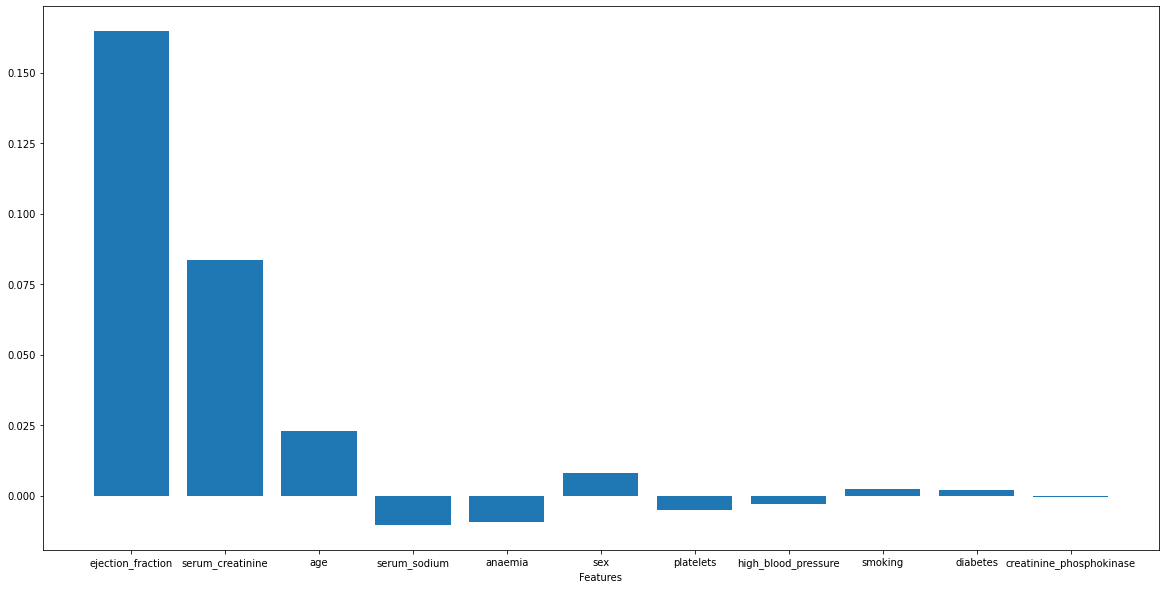

In [33]:
plt.figure(figsize=(20,10))

# perform permutation importance
results = permutation_importance(rf_tune, X_test_sc, y_test, scoring='roc_auc')
# get importance
importance = results.importances_mean
# summarize feature importance
importance_pairs = pd.DataFrame(zip(X_test.columns, importance), columns= ["feature", "importance"])
importance_pairs.sort_values(by='importance', ascending=False, ignore_index=True, inplace=True, key=abs)

for i,v in enumerate(importance):
    print(f'{X_test.columns[i]}, Score: {np.round(v, decimals=4)}')
# plot feature importance
plt.bar(importance_pairs.iloc[:,0], importance_pairs.iloc[:,1])
plt.xlabel("Features")
plt.show()

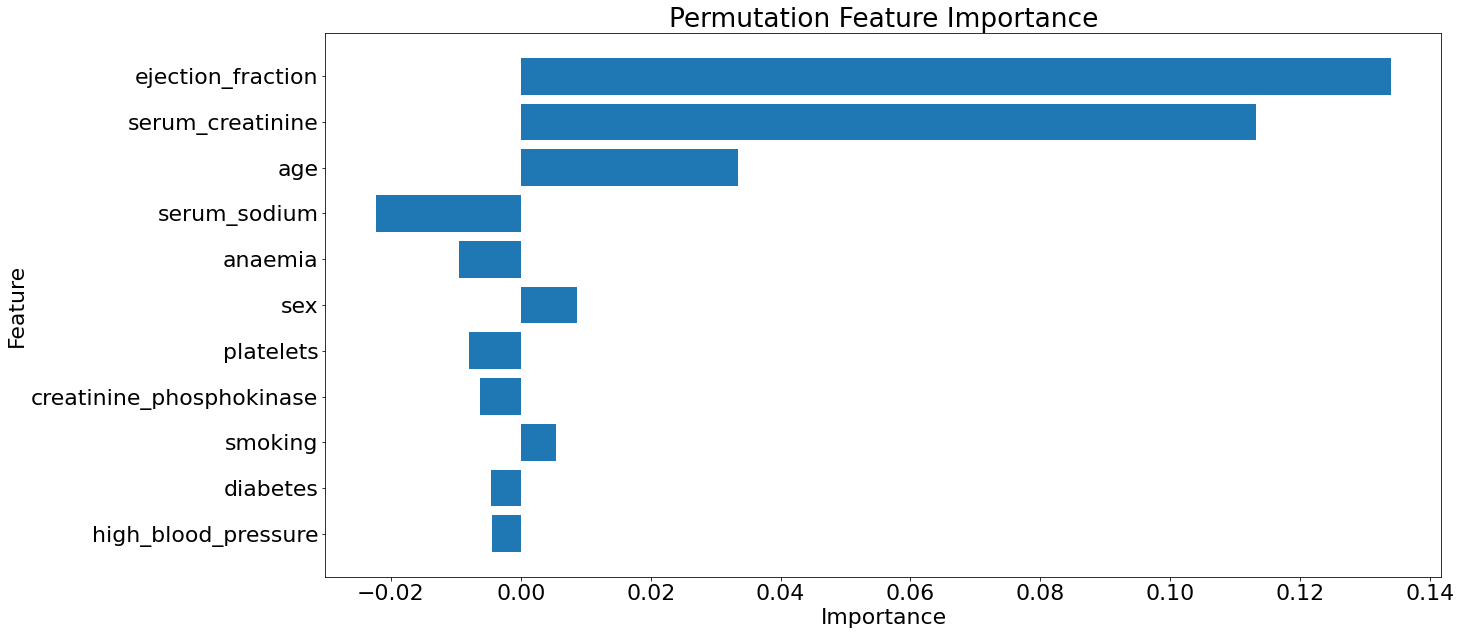

In [83]:
from sklearn.inspection import permutation_importance

plt.figure(figsize=(20,10))
results = permutation_importance(rf_tune, X_test_sc, y_test, scoring='roc_auc')
importance = results.importances_mean
importance_pairs = pd.DataFrame(zip(X_test.columns, importance), columns= ["feature", "importance"])
importance_pairs.sort_values(by='importance', ascending=True, ignore_index=True, inplace=True, key=abs)

plt.barh(importance_pairs.iloc[:,0], importance_pairs.iloc[:,1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.rcParams.update({'font.size': 22})
plt.title("Permutation Feature Importance")
plt.show()